In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [13]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [14]:
class DNN_7(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_7, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn3(self.layer3(x)))

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout2(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [15]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [16]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整

    # モデル定義
    model = DNN_7(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [17]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-12 21:01:32,885] A new study created in memory with name: no-name-783c4947-4995-440d-ab68-2bc5a962687f


/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:39,991] Trial 0 finished with value: 0.19540513191048425 and parameters: {'dropout1': 0.1, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00031798345734489224, 'weight_decay': 0.08059934771408304}. Best is trial 0 with value: 0.19540513191048425.


Early stopping at epoch 50
Final MCC: 0.1954


/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:43,940] Trial 1 finished with value: 0.10866363883885687 and parameters: {'dropout1': 0.25, 'dropout2': 0.2, 'learning_rate': 0.0044767140153061345, 'weight_decay': 0.0006856235822442478}. Best is trial 0 with value: 0.19540513191048425.


Early stopping at epoch 28
Final MCC: 0.1087


/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:51,292] Trial 2 finished with value: 0.314309934363615 and parameters: {'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00044830591612477204, 'weight_decay': 0.000965986281943581}. Best is trial 2 with value: 0.314309934363615.


Early stopping at epoch 52
Final MCC: 0.3143


/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:55,586] Trial 3 finished with value: 0.0 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.0009969732321170339, 'weight_decay': 0.0003702546035625538}. Best is trial 2 with value: 0.314309934363615.


Early stopping at epoch 31
Final MCC: 0.0000


/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:58,722] Trial 4 finished with value: 0.15685355557141883 and parameters: {'dropout1': 0.4, 'dropout2': 0.1, 'learning_rate': 0.01779946657515538, 'weight_decay': 5.301233805967402e-05}. Best is trial 2 with value: 0.314309934363615.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in

Early stopping at epoch 22
Final MCC: 0.1569


[I 2024-12-12 21:01:59,029] Trial 6 pruned. 
[I 2024-12-12 21:01:59,196] Trial 7 pruned. 
[I 2024-12-12 21:02:07,389] Trial 8 finished with value: 0.10078969375816504 and parameters: {'dropout1': 0.25, 'dropout2': 0.4, 'learning_rate': 0.0006096843287771189, 'weight_decay': 0.02584841868007996}. Best is trial 2 with value: 0.314309934363615.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 20

Early stopping at epoch 59
Final MCC: 0.1008


[I 2024-12-12 21:02:07,702] Trial 10 pruned. 
[I 2024-12-12 21:02:20,586] Trial 11 finished with value: 0.10701775630362755 and parameters: {'dropout1': 0.05, 'dropout2': 0.25, 'learning_rate': 0.00013779710953381786, 'weight_decay': 0.0976871519662701}. Best is trial 2 with value: 0.314309934363615.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:02:20,756] Trial 12 pruned. 


Early stopping at epoch 92
Final MCC: 0.1070


[I 2024-12-12 21:02:33,086] Trial 13 finished with value: 0.32230645338464786 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00026425350140806025, 'weight_decay': 1.1164964225930149e-05}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:02:33,251] Trial 14 pruned. 


Early stopping at epoch 88
Final MCC: 0.3223


[I 2024-12-12 21:02:33,424] Trial 15 pruned. 
[I 2024-12-12 21:02:33,598] Trial 16 pruned. 
[I 2024-12-12 21:02:37,183] Trial 17 finished with value: 0.1654797217667127 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0013362869940298336, 'weight_decay': 0.015767657211824073}. Best is trial 13 with value: 0.32230645338464786.


Early stopping at epoch 25
Final MCC: 0.1655


/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:02:50,899] Trial 18 finished with value: 0.06043314756960064 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.0002282580621568178, 'weight_decay': 0.001800514470292604}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform h

Final MCC: 0.0604


[I 2024-12-12 21:02:51,225] Trial 20 pruned. 
[I 2024-12-12 21:02:51,404] Trial 21 pruned. 
[I 2024-12-12 21:02:51,597] Trial 22 pruned. 
[I 2024-12-12 21:02:51,782] Trial 23 pruned. 
[I 2024-12-12 21:02:51,940] Trial 24 pruned. 
[I 2024-12-12 21:02:52,131] Trial 25 pruned. 
[I 2024-12-12 21:02:52,289] Trial 26 pruned. 
[I 2024-12-12 21:02:52,450] Trial 27 pruned. 
[I 2024-12-12 21:02:52,631] Trial 28 pruned. 
[I 2024-12-12 21:02:52,791] Trial 29 pruned. 
[I 2024-12-12 21:02:52,959] Trial 30 pruned. 
[I 2024-12-12 21:02:53,119] Trial 31 pruned. 
[I 2024-12-12 21:02:53,289] Trial 32 pruned. 
[I 2024-12-12 21:02:53,479] Trial 33 pruned. 
[I 2024-12-12 21:02:53,645] Trial 34 pruned. 
[I 2024-12-12 21:02:53,819] Trial 35 pruned. 
[I 2024-12-12 21:02:53,984] Trial 36 pruned. 
[I 2024-12-12 21:02:54,152] Trial 37 pruned. 
[I 2024-12-12 21:02:54,324] Trial 38 pruned. 
[I 2024-12-12 21:03:04,159] Trial 39 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.

Early stopping at epoch 72
Final MCC: 0.0000


/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:03:11,515] Trial 40 finished with value: 0.18457240181234186 and parameters: {'dropout1': 0.25, 'dropout2': 0.1, 'learning_rate': 0.0006052340665846924, 'weight_decay': 0.004363460704765345}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been depreca

Early stopping at epoch 56
Final MCC: 0.1846


[I 2024-12-12 21:03:11,849] Trial 42 pruned. 
[I 2024-12-12 21:03:12,025] Trial 43 pruned. 
[I 2024-12-12 21:03:25,023] Trial 44 finished with value: 0.18773682623354143 and parameters: {'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00038884072837178075, 'weight_decay': 0.0077749183222552065}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e

Early stopping at epoch 95
Final MCC: 0.1877


[I 2024-12-12 21:03:35,699] Trial 46 finished with value: 0.2359356346263649 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.2, 'learning_rate': 0.00039551102186661857, 'weight_decay': 0.0005386808101082163}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:03:35,845] Trial 47 pruned. 


Early stopping at epoch 78
Final MCC: 0.2359


[I 2024-12-12 21:03:36,003] Trial 48 pruned. 
[I 2024-12-12 21:03:36,211] Trial 49 pruned. 
[I 2024-12-12 21:03:36,389] Trial 50 pruned. 
[I 2024-12-12 21:03:36,572] Trial 51 pruned. 
[I 2024-12-12 21:03:36,735] Trial 52 pruned. 
[I 2024-12-12 21:03:36,908] Trial 53 pruned. 
[I 2024-12-12 21:03:37,084] Trial 54 pruned. 
[I 2024-12-12 21:03:37,262] Trial 55 pruned. 
[I 2024-12-12 21:03:51,052] Trial 56 finished with value: 0.28195567008791605 and parameters: {'dropout1': 0.25, 'dropout2': 0.05, 'learning_rate': 0.00017340411273041509, 'weight_decay': 0.0001989889614854079}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: Futu

Final MCC: 0.2820


[I 2024-12-12 21:03:51,401] Trial 58 pruned. 
[I 2024-12-12 21:03:51,557] Trial 59 pruned. 
[I 2024-12-12 21:03:51,733] Trial 60 pruned. 
[I 2024-12-12 21:03:51,909] Trial 61 pruned. 
[I 2024-12-12 21:04:04,082] Trial 62 finished with value: 0.2382666618144388 and parameters: {'dropout1': 0.25, 'dropout2': 0.1, 'learning_rate': 0.00022925470954995728, 'weight_decay': 0.009030674619455253}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

Early stopping at epoch 88
Final MCC: 0.2383


[I 2024-12-12 21:04:04,405] Trial 64 pruned. 
[I 2024-12-12 21:04:04,559] Trial 65 pruned. 
[I 2024-12-12 21:04:04,720] Trial 66 pruned. 
[I 2024-12-12 21:04:04,894] Trial 67 pruned. 
[I 2024-12-12 21:04:05,068] Trial 68 pruned. 
[I 2024-12-12 21:04:05,245] Trial 69 pruned. 
[I 2024-12-12 21:04:13,212] Trial 70 finished with value: 0.19313656219880884 and parameters: {'dropout1': 0.2, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0004664642679458269, 'weight_decay': 1.1483134539901665e-05}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will

Early stopping at epoch 58
Final MCC: 0.1931


[I 2024-12-12 21:04:13,559] Trial 72 pruned. 
[I 2024-12-12 21:04:27,427] Trial 73 finished with value: 0.1699266115265765 and parameters: {'dropout1': 0.2, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0003800282112827362, 'weight_decay': 1.0046213020417556e-05}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:04:27,599] 

Final MCC: 0.1699


[I 2024-12-12 21:04:27,759] Trial 75 pruned. 
[I 2024-12-12 21:04:27,931] Trial 76 pruned. 
[I 2024-12-12 21:04:28,110] Trial 77 pruned. 
[I 2024-12-12 21:04:29,629] Trial 78 finished with value: 0.0 and parameters: {'dropout1': 0.1, 'dropout2': 0.25, 'learning_rate': 0.00012312242372087295, 'weight_decay': 0.030638003842735472}. Best is trial 13 with value: 0.32230645338464786.
/tmp/ipykernel_1419439/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1419439/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weig

Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-12 21:04:29,968] Trial 80 pruned. 
[I 2024-12-12 21:04:30,134] Trial 81 pruned. 
[I 2024-12-12 21:04:30,298] Trial 82 pruned. 
[I 2024-12-12 21:04:30,467] Trial 83 pruned. 
[I 2024-12-12 21:04:30,635] Trial 84 pruned. 
[I 2024-12-12 21:04:30,797] Trial 85 pruned. 
[I 2024-12-12 21:04:30,954] Trial 86 pruned. 
[I 2024-12-12 21:04:31,118] Trial 87 pruned. 
[I 2024-12-12 21:04:31,295] Trial 88 pruned. 
[I 2024-12-12 21:04:31,468] Trial 89 pruned. 
[I 2024-12-12 21:04:31,635] Trial 90 pruned. 
[I 2024-12-12 21:04:31,815] Trial 91 pruned. 
[I 2024-12-12 21:04:32,000] Trial 92 pruned. 
[I 2024-12-12 21:04:32,178] Trial 93 pruned. 
[I 2024-12-12 21:04:32,375] Trial 94 pruned. 
[I 2024-12-12 21:04:32,551] Trial 95 pruned. 
[I 2024-12-12 21:04:32,727] Trial 96 pruned. 
[I 2024-12-12 21:04:32,889] Trial 97 pruned. 
[I 2024-12-12 21:04:33,058] Trial 98 pruned. 
[I 2024-12-12 21:04:33,239] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00026425350140806025, 'weight_decay': 1.1164964225930149e-05}
Best Validation F1:  0.32230645338464786


In [18]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_7_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/50], Loss: 0.6964
Epoch [1/50], Train Loss: 0.6964, Val Loss: 0.7118
Epoch [2/50], Loss: 0.6852
Epoch [2/50], Train Loss: 0.6852, Val Loss: 0.6826
Epoch [3/50], Loss: 0.6736
Epoch [3/50], Train Loss: 0.6736, Val Loss: 0.6700
Epoch [4/50], Loss: 0.6632
Epoch [4/50], Train Loss: 0.6632, Val Loss: 0.6622
Epoch [5/50], Loss: 0.6589
Epoch [5/50], Train Loss: 0.6589, Val Loss: 0.6540
Epoch [6/50], Loss: 0.6505
Epoch [6/50], Train Loss: 0.6505, Val Loss: 0.6418
Epoch [7/50], Loss: 0.6393
Epoch [7/50], Train Loss: 0.6393, Val Loss: 0.6397
Epoch [8/50], Loss: 0.6383
Epoch [8/50], Train Loss: 0.6383, Val Loss: 0.6325
Epoch [9/50], Loss: 0.6278
Epoch [9/50], Train Loss: 0.6278, Val Loss: 0.6296
Epoch [10/50], Loss: 0.6246
Epoch [10/50], Train Loss: 0.6246, Val Loss: 0.6257
Epoch [11/50], Loss: 0.6206
Epoch [11/50], Train Loss: 0.6206, Val Loss: 0.6229
Epoch [12/50], Loss: 0.6193
Epoch [12/50], Train Loss: 0.6193, Val Loss: 0.6175
Epoch [13/50], Loss: 0.6173
Epoch [13/50], Train Loss: 0.6

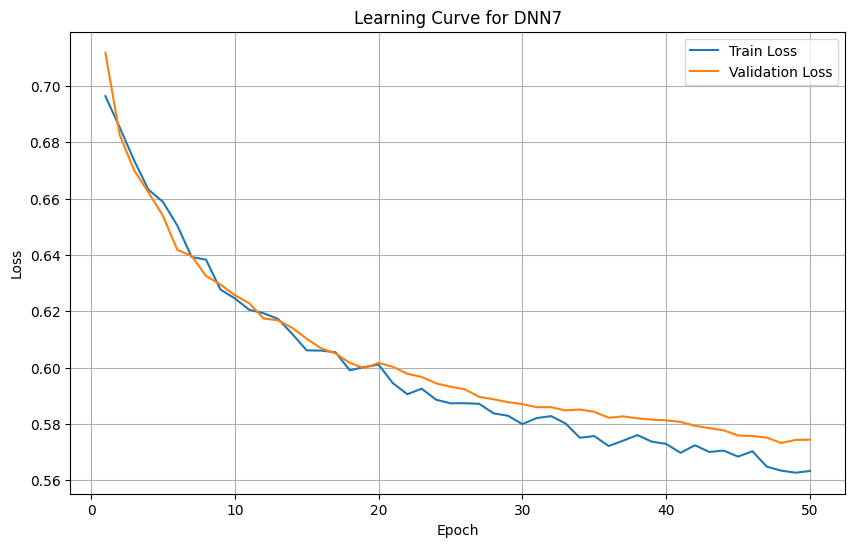

In [45]:
best_params=study.best_params
model = DNN_7(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=50
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN7')
plt.legend()
plt.grid()
plt.show()

Accuracy: 59.11%
Precision: 0.4777
Recall: 0.6313
F1 Score: 0.5438
Matthews Correlation Coefficient: 0.1920
Specificity: 0.5659


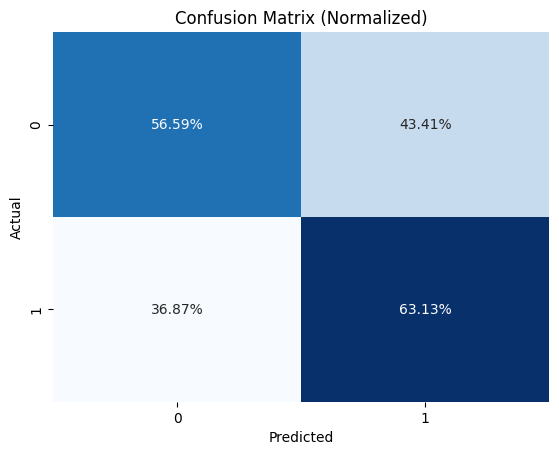

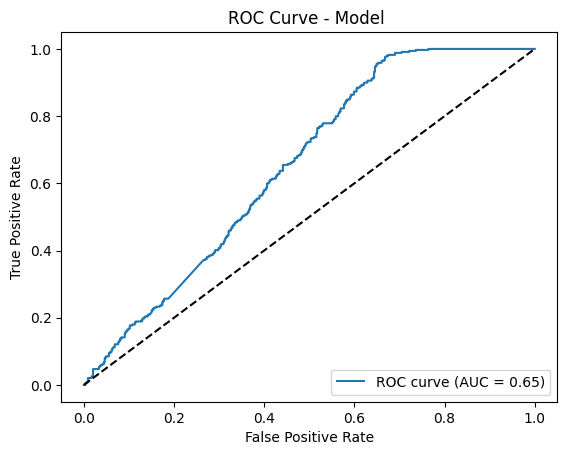

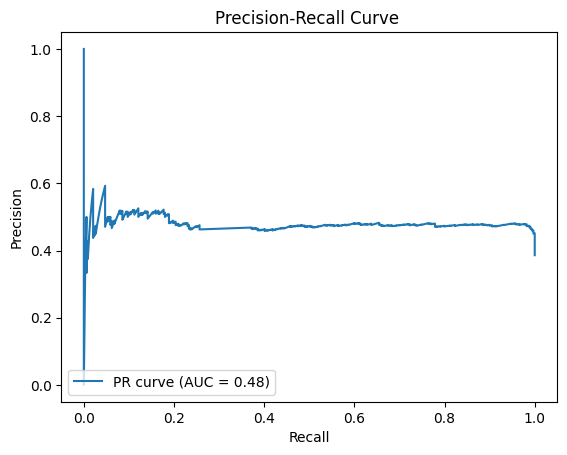

In [46]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [21]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_7.pth')




In [22]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
            Linear-3                   [-1, 16]             528
       BatchNorm1d-4                   [-1, 16]              32
           Dropout-5                   [-1, 16]               0
            Linear-6                    [-1, 8]             136
       BatchNorm1d-7                    [-1, 8]              16
            Linear-8                    [-1, 4]              36
       BatchNorm1d-9                    [-1, 4]               8
          Dropout-10                    [-1, 4]               0
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back